In [1]:
import numpy as np

# Load the results file from the local "Results" folder
results_path = "Results/results_RF_EI_16.npz"
results_data = np.load(results_path)

# List available keys in the results file
results_keys = results_data.files

print(results_keys)


['Xs', 'Ys', 'bests', 'max_wells', 'batch_size']


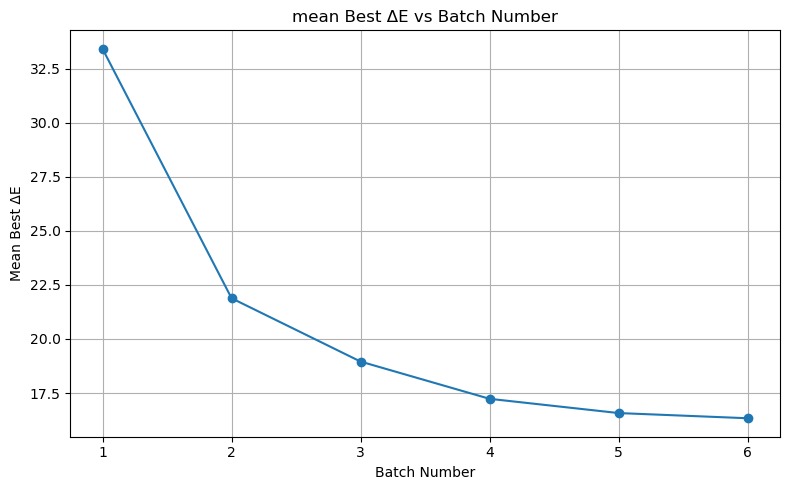

In [2]:
import matplotlib.pyplot as plt

# Extract relevant data
bests = results_data['bests']
mean_best_deltaE = bests.mean(axis=0)


# Plotting average deltaE vs. batch number
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mean_best_deltaE) + 1), mean_best_deltaE, marker='o')
plt.xlabel("Batch Number")
plt.ylabel("Mean Best ΔE")
plt.title("mean Best ΔE vs Batch Number")
plt.grid(True)
plt.tight_layout()
plt.show()


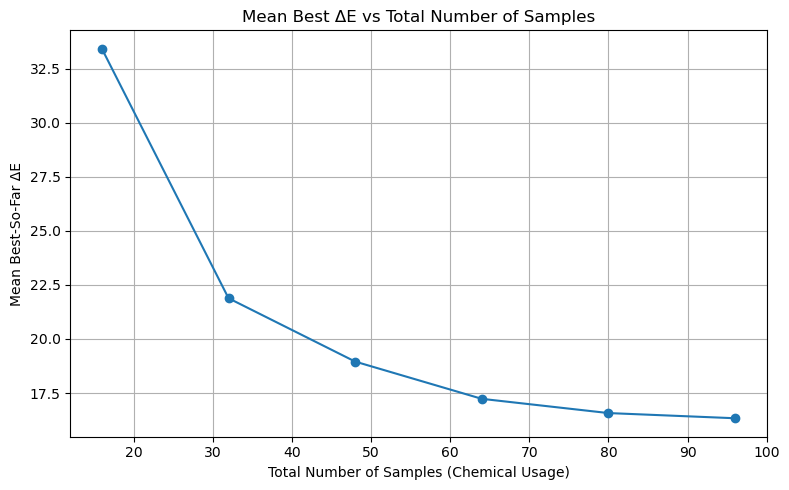

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
results = np.load("Results/results_RF_EI_16.npz")
bests = results["bests"]  # shape: (num_trials, num_batches)
batch_size = int(results["batch_size"])

# Calculate mean best-so-far ΔE across trials
mean_best_deltaE = bests.mean(axis=0)

# Total samples = cumulative samples = batch_number × batch_size
total_samples = np.arange(1, len(mean_best_deltaE) + 1) * batch_size

# Plot
plt.figure(figsize=(8, 5))
plt.plot(total_samples, mean_best_deltaE, marker='o')
plt.xlabel("Total Number of Samples (Chemical Usage)")
plt.ylabel("Mean Best-So-Far ΔE")
plt.title("Mean Best ΔE vs Total Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


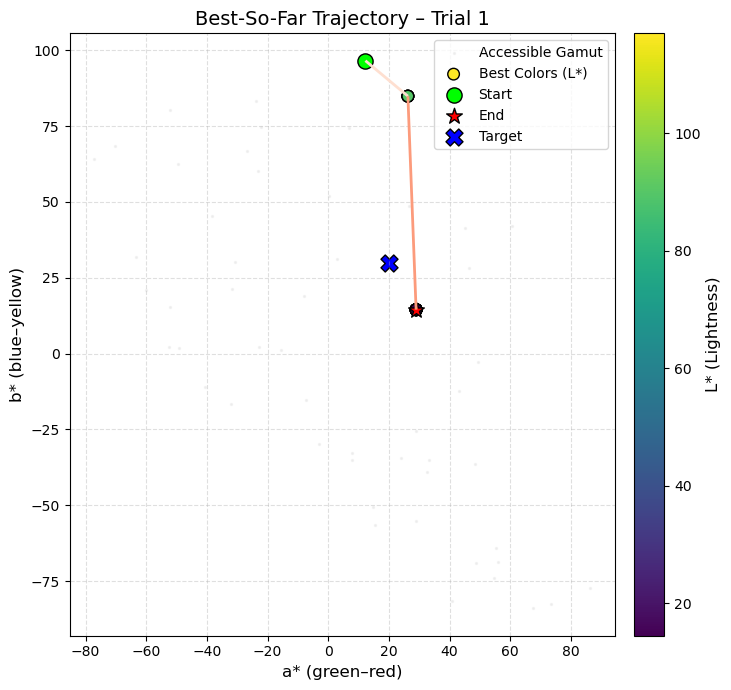

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from skimage.color import lab2rgb
import warnings


# Load data
results = np.load("Results/results_RF_EI_16.npz")
Xs = results["Xs"]       # (50, num_batches, batch_size, 3)
Ys = results["Ys"]
gamut = np.load("uniform_lab_from_rgb.npy")

# Select trial
trial_index = 0
xs_trial = Xs[trial_index]         # (num_batches, batch_size, 3)
ys_trial = Ys[trial_index]         # (num_batches * batch_size,)
xs_trial_flat = xs_trial.reshape(-1, 3)
ys_trial_flat = ys_trial

# Track best-so-far colors
best_colors = []
best_so_far = np.inf
best_color = None

for i in range(len(ys_trial_flat)):
    deltaE = ys_trial_flat[i]
    if deltaE < best_so_far:
        best_so_far = deltaE
        best_color = xs_trial_flat[i]
    best_colors.append(best_color)

best_colors = np.array(best_colors)  # (num_batches * batch_size, 3)

# Use last best color in each batch
batch_size = xs_trial.shape[1]
best_colors_per_batch = best_colors[batch_size-1::batch_size]  # (num_batches, 3)

# a*, b*, and L* values
a_vals_b = best_colors_per_batch[:, 1]
b_vals_b = best_colors_per_batch[:, 2]
L_vals_b = best_colors_per_batch[:, 0]

# Line segments: black → red
points = np.array([a_vals_b, b_vals_b]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='Reds', norm=plt.Normalize(0, len(a_vals_b) - 1))
lc.set_array(np.arange(len(a_vals_b) - 1))
lc.set_linewidth(2)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Gamut background
ax.scatter(gamut[:, 1], gamut[:, 2], c='lightgray', s=2, alpha=0.25, label='Accessible Gamut')

# Add connecting line
ax.add_collection(lc)

# Scatter points colored by L* (lightness)
sc = ax.scatter(a_vals_b, b_vals_b, c=L_vals_b, cmap='viridis', s=70, edgecolor='k', label='Best Colors (L*)')

# Start and end markers
ax.scatter(a_vals_b[0], b_vals_b[0], c='lime', s=120, marker='o', edgecolor='black', label='Start')
ax.scatter(a_vals_b[-1], b_vals_b[-1], c='red', s=140, marker='*', edgecolor='black', label='End')

# Target point (update if needed)
target_lab = np.array([50, 20, 30])
ax.scatter(target_lab[1], target_lab[2], c='blue', s=150, marker='X', edgecolor='black', label='Target')

# Formatting
ax.set_title(f'Best-So-Far Trajectory – Trial {trial_index+1}', fontsize=14)
ax.set_xlabel('a* (green–red)', fontsize=12)
ax.set_ylabel('b* (blue–yellow)', fontsize=12)
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label('L* (Lightness)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(fontsize=10)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()
